In [1]:
import json
import tensorflow as tf
from keras.optimizers import *

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

2.0.0-beta0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2019-11-04 07:51:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:4005:802::2010, 172.217.0.48
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:4005:802::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  2.14MB/s    in 2.5s    

2019-11-04 07:51:34 (2.14 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [17]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000
batch_size=32
epochs=20

with open("./sarcasm_data.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("training_padded: "+str(training_padded.shape))
print(str(training_padded))

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print("testing_padded: "+str(testing_padded.shape))
print(str(testing_padded))


training_padded: (20000, 120)
[[328   1 799 ...   0   0   0]
 [  4   1   1 ...   0   0   0]
 [153 890   2 ...   0   0   0]
 ...
 [ 79   1   1 ...   0   0   0]
 [ 53   1   1 ...   0   0   0]
 [312 705   1 ...   0   0   0]]
testing_padded: (6709, 120)
[[  1   1   1 ...   0   0   0]
 [202   1   8 ...   0   0   0]
 [ 18 380 191 ...   0   0   0]
 ...
 [  1   9  67 ...   0   0   0]
 [  1 374   1 ...   0   0   0]
 [  1   1   6 ...   0   0   0]]


In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 120, 64)           12544     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 120, 64)           24832     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 86,657
Trainable params: 86,657
Non-trainable params: 0
__________________________________________________

In [20]:
history = model.fit(training_padded, 
                    training_labels, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(testing_padded, testing_labels),
                    verbose=1)

Train on 20000 samples, validate on 6709 samples
Epoch 1/20
20000/20000 [==============================] - 131s 7ms/sample - loss: 0.4526 - accuracy: 0.7764 - val_loss: 0.3833 - val_accuracy: 0.8252
Epoch 2/20
20000/20000 [==============================] - 127s 6ms/sample - loss: 0.3496 - accuracy: 0.8400 - val_loss: 0.3732 - val_accuracy: 0.8298
Epoch 3/20
20000/20000 [==============================] - 127s 6ms/sample - loss: 0.3218 - accuracy: 0.8569 - val_loss: 0.3716 - val_accuracy: 0.8301
Epoch 4/20
20000/20000 [==============================] - 125s 6ms/sample - loss: 0.3064 - accuracy: 0.8644 - val_loss: 0.3731 - val_accuracy: 0.8307
Epoch 5/20
20000/20000 [==============================] - 124s 6ms/sample - loss: 0.2950 - accuracy: 0.8712 - val_loss: 0.3789 - val_accuracy: 0.8296
Epoch 6/20
20000/20000 [==============================] - 173s 9ms/sample - loss: 0.2848 - accuracy: 0.8757 - val_loss: 0.3899 - val_accuracy: 0.8319
Epoch 7/20
20000/20000 [===========================

In [21]:
print(str(history.history))

{'loss': [0.452588023352623, 0.3495958488225937, 0.3218192756295204, 0.30643332884311675, 0.2949669448852539, 0.28481763298511503, 0.27502700840234756, 0.2665080530047417, 0.25816614938378335, 0.2508760371685028, 0.24202128427028655, 0.23242273389697074, 0.2233180825471878, 0.21380095320343973, 0.203770835891366, 0.1956229976594448, 0.19055615043342114, 0.1780752174347639, 0.17335224894285203, 0.17166155585348605], 'accuracy': [0.77645, 0.84, 0.85695, 0.86445, 0.8712, 0.8757, 0.8812, 0.88455, 0.88985, 0.8901, 0.8955, 0.89935, 0.9021, 0.9069, 0.91205, 0.91625, 0.91785, 0.9222, 0.9248, 0.92445], 'val_loss': [0.38334389627734994, 0.3731706485758597, 0.37159457394539785, 0.37306681067031333, 0.37892963051938106, 0.3898595507373432, 0.38976199873639106, 0.40606721239307453, 0.41200601819162486, 0.45246925806569205, 0.4515320113588684, 0.452423728175127, 0.4690527514385065, 0.49222547195675226, 0.49196934257574987, 0.5153836410213359, 0.5380659953263925, 0.5981756265907213, 0.666625888985694

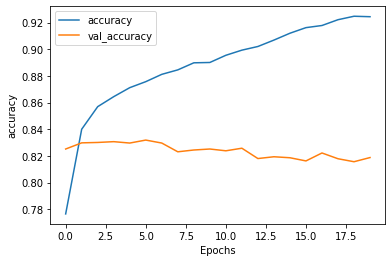

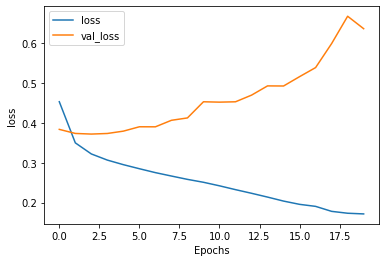

In [22]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [23]:
model.save("test.h5")